In [1]:
!pip install statsmodels

In [2]:
import os
import pandas as pd
import zipfile
import numpy as np
import tensorflow as tf
print(tf.__version__)
import h5py
import random
from scipy import ndimage
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from statsmodels.stats.proportion import proportion_confint
import sklearn
import tempfile
import gc
import shutil
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import Session
from functions.auc_delong_xu import auc_ci_Delong

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical

from keras import models
from keras.models import Model
from keras import layers
from keras.layers import Activation
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Input
from keras.layers import BatchNormalization
from keras.layers import Conv3D
from keras.layers import MaxPooling3D
from keras.layers import AveragePooling3D
from keras.layers import Dropout
from keras.layers import Reshape
from keras.layers import Lambda
from keras.layers import GlobalAveragePooling3D
from keras_kinetics_i3d.i3d_inception import Inception_Inflated3d

from keras.engine.topology import get_source_inputs
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras import backend as K

2.4.0


### Import data from HD5File

In [3]:
#PATH_3D_H5 = 'Images/tof_data.hdf5'
PATH_3D_H5 = 'Images/tof_data_128_112_40.hdf5'
#PATH_3D_H5 = 'Images/tof_data_160_140_50.hdf5'

In [4]:
with h5py.File(PATH_3D_H5, 'r') as dd:
    print(list(dd.keys()))
    print(dd['X'].shape)
    print(dd['stroke'].shape)

['X', 'pat', 'path', 'stroke']
(508, 128, 112, 40)
(508,)


In [5]:
def decode_data(string):
    decoded_string = [n.decode("UTF-8", "ignore") for n in string]
    return(decoded_string)

with h5py.File(PATH_3D_H5, 'r') as h5:
    print('H5-file: ', list(h5.keys()))
    
    # Image matrices
    X = h5["X"][:]
    # Patient ID's
    pat = h5["pat"][:]
    # Path to images
    path = decode_data(h5["path"][:])
    # Patient labels (1=stroke, 0=TIA)
    Y_pat = h5["stroke"][:]
    
print(len(X), len(Y_pat), len(pat), len(path))

H5-file:  ['X', 'pat', 'path', 'stroke']
508 508 508 508


### Train, validation, test split (vgl. NB Lisa)

There are 508 patients with TOF-MRA images. We split the dataset in a training and test set.
- Training set: 407 images (~80%) -> 281 stroke, 126 non-stroke
- Test set: 101 images (~20%) -> 70 stroke, 31 non-stroke

In [6]:
# consider stroke and no-stroke patients separately:
idx = np.where(Y_pat == 1)[0]
stroke_patients = np.unique(pat[idx])
idx = np.where(Y_pat == 0)[0]
non_stroke_patients = np.unique(pat[idx])
print(len(stroke_patients), len(non_stroke_patients))

# randomly shuffle the stroke and non-stroke patients
np.random.seed(1)
stroke_patients_test = np.random.choice(stroke_patients, size=len(stroke_patients), replace=False)
non_stroke_patients_test = np.random.choice(non_stroke_patients, size=len(non_stroke_patients), replace=False)

#test set
np.random.seed(1)
test_tmp = np.concatenate([stroke_patients_test[:70], non_stroke_patients_test[:32]], axis=0)
test = np.random.choice(test_tmp, size=len(test_tmp), replace=False)
len(test)

stroke_patients_run = [i for i in stroke_patients if i not in test]
non_stroke_patients_run = [i for i in non_stroke_patients if i not in test]

# randomply shuffle the data
np.random.seed(100)
stroke_patients_tmp = np.random.choice(stroke_patients_run, size=len(stroke_patients_run), replace=False)
non_stroke_patients_tmp = np.random.choice(non_stroke_patients_run, size=len(non_stroke_patients_run), replace=False)
print(len(stroke_patients_tmp), len(non_stroke_patients_tmp))

train_tmp = np.concatenate([stroke_patients_tmp[0:211],non_stroke_patients_tmp[:93]], axis=0)
valid_tmp = np.concatenate([stroke_patients_tmp[211:len(stroke_patients_tmp)], non_stroke_patients_tmp[93:len(non_stroke_patients)]], axis=0)
print(len(train_tmp), len(valid_tmp))

# randomly shuffle the datasets such that stroke and no-stroke patients are mixed
np.random.seed(100)
train = np.random.choice(train_tmp, size=len(train_tmp), replace=False)
valid = np.random.choice(valid_tmp, size=len(valid_tmp), replace=False)
test = np.random.choice(test, size=len(test), replace=False)
print(len(train), len(valid), len(test))

351 157
281 125
304 102
304 102 102


In [7]:
def get_datasets(set_i, X, Y_pat, pat, path):
    Y_pat_set = []
    pat_set = []
    path_set = []
    # Find the indices corresponding to the patient_i in set_i
    idx = [i for i, pat_i in enumerate(pat) if pat_i in set_i]
    X_set = X[idx,:,:,:]
    for i in idx:
        Y_pat_set.append(Y_pat[i])
        pat_set.append(pat[i])
        path_set.append(path[i])     
    return(X_set, np.array(Y_pat_set), np.array(pat_set), np.array(path_set))

In [46]:
X_train, Y_train, pat_train, path_train = get_datasets(train, X, Y_pat, pat, path)
X_valid, Y_valid, pat_valid, path_valid = get_datasets(valid, X, Y_pat, pat, path)
X_test, Y_test, pat_test, path_test = get_datasets(test, X, Y_pat, pat, path)

In [47]:
#for softmax
Y_train = to_categorical(Y_train)
Y_valid = to_categorical(Y_valid)
Y_test = to_categorical(Y_test)

### Preprocess data

In [30]:
#IMAGE_DIMENSION = (64, 56, 20)
#IMAGE_DIMENSION = (96, 84, 30)
IMAGE_DIMENSION = (128, 112, 40)
#IMAGE_DIMENSION = (128, 128, 40)

#### Resize images 

In [31]:
def normalize_array(array):
    min = np.min(array)
    max = np.max(array)
    normalized = (array - min) / (max - min)
    return normalized

In [18]:
def resize_volume(img):
    """Resize across z-axis"""
    # Set the desired depth
    desired_width = IMAGE_DIMENSION[0]
    desired_height = IMAGE_DIMENSION[1]
    desired_depth = IMAGE_DIMENSION[2]
    # Get current depth
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    # Resize across z-axis
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    img = normalize_array(img)
    return img

In [10]:
X_train = np.array([resize_volume(img) for img in X_train])
X_test = np.array([resize_volume(img) for img in X_test])

NameError: name 'resize_volume' is not defined

In [32]:
X_train = np.array([normalize_array(img) for img in X_train])
X_valid = np.array([normalize_array(img) for img in X_valid])

#### Expand dimensions

In [60]:
X_train = np.expand_dims(X_train, axis = 4)
X_valid= np.expand_dims(X_valid, axis = 4)

In [48]:
X_test = np.expand_dims(X_test, axis = 4)

#### Add channels to images -> 1 to 3

In [61]:
X_train = np.repeat(X_train, 3, -1)
X_valid = np.repeat(X_valid, 3, -1)    

In [49]:
X_test = np.repeat(X_test, 3, -1)  

### Move depth axis

In [62]:
X_train = np.moveaxis(X_train, 3, 1)
X_train.shape

(304, 40, 128, 112, 3)

In [63]:
X_valid = np.moveaxis(X_valid, 3, 1)
X_valid.shape

(102, 40, 128, 112, 3)

In [50]:
X_test = np.moveaxis(X_test, 3, 1)

#### Check if values are betwwen 0 and 1

In [33]:
print(np.min(X_train), np.max(X_train))

0.0 1.0


In [64]:
X_train = (X_train - X_train.mean()) / X_train.std()
X_valid = (X_valid - X_valid.mean()) / X_valid.std()

In [51]:
X_test = (X_test - X_test.mean()) / X_test.std()

##### Optional: all elements between -0.5 and 0.5

In [337]:
##all elements between -0.5 and 0.5
X_train = X_train - 0.5
X_test = X_test - 0.5

In [338]:
print(np.min(X_train[0]), np.max(X_train[0]))

-0.5 0.5


### Data Augmentation

Zoom images

In [16]:
# zoom
def random_zoom3d(X_im, min_zoom, max_zoom):
    z = np.random.sample() *(max_zoom-min_zoom) + min_zoom
    zoom_matrix = np.array([[z, 0, 0, 0],
                            [0, z, 0, 0],
                            [0, 0, z, 0],
                            [0, 0, 0, 1]])
    return ndimage.affine_transform(X_im, zoom_matrix, mode = "nearest", order = 1)

In [120]:
X_aug = random_zoom3d(X, 0.8, 1.3)
#plot_slices(4, 10, 128, 112, X_aug[:, :, :])
#fig, ax = plt.subplots()
#pos = ax.imshow(np.squeeze(X_aug[:, :, 10]), cmap="gray")

Rotate images

In [17]:
# rotate
def random_rotate3d(X_im, min_angle_xy, max_angle_xy, min_angle_xz, max_angle_xz, min_angle_yz, max_angle_yz):
    angle_xy = np.random.uniform(min_angle_xy, max_angle_xy)
    angle_xz = np.random.uniform(min_angle_xz, max_angle_xz)
    angle_yz = np.random.uniform(min_angle_yz, max_angle_yz)
    rotation_axis = np.random.choice([0,1,2])
    if(rotation_axis == 0):
        X_im = ndimage.rotate(X_im, angle = angle_xy, axes = (0,1), mode = "nearest", reshape = False, order = 3)
    if(rotation_axis == 1):
        X_im = ndimage.rotate(X_im, angle = angle_xz, axes = (0,2), mode = "nearest", reshape = False, order = 3)
    if(rotation_axis == 2):
        X_im = ndimage.rotate(X_im, angle = angle_yz, axes = (1,2), mode = "nearest", reshape = False, order = 3)
    return X_im

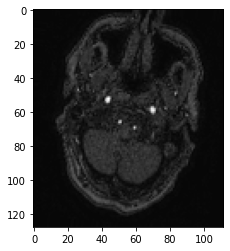

In [36]:
X_aug = random_rotate3d(X, -20, 20, -5, 5, -5, 5)
fig, ax = plt.subplots()
pos = ax.imshow(np.squeeze(X_aug[:, :, 10]), cmap="gray")

Shifting images

In [18]:
# shifting
def random_shift3d(X_im, min_shift_x, max_shift_x, min_shift_y, max_shift_y, min_shift_z, max_shift_z):
    x_shift = np.random.uniform(min_shift_x, max_shift_x)
    y_shift = np.random.uniform(min_shift_y, max_shift_y)
    z_shift = np.random.uniform(min_shift_z, max_shift_z)
    return ndimage.shift(X_im, [x_shift, y_shift, z_shift, 0], mode = "nearest", order = 0)

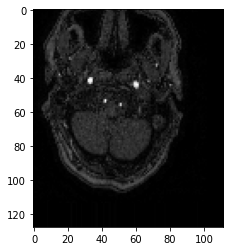

In [39]:
X_aug = random_shift3d(X, -20, 20, -20, 20, 0, 0)
fig, ax = plt.subplots()
pos = ax.imshow(np.squeeze(X_aug[:, :, 10]), cmap="gray")

Flipping images

In [19]:
def random_flip3d(X_im):
    axis = np.random.choice([0,1])
    if(axis == 0): # vertical flip
        X_im = X_im[:,::-1,:,:]
        # X_im = X_im[::-1,:,:,:] #horizontal
        # X_im = np.asarray(X_im).swapaxes(0, 1)#left, right flip
    return X_im

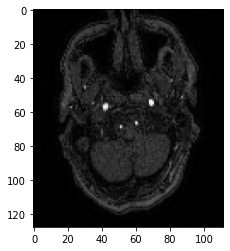

In [45]:
X_aug = random_flip3d(X)
fig, ax = plt.subplots()
pos = ax.imshow(np.squeeze(X_aug[:, :, 10]), cmap="gray")

Gauss filter

In [20]:
# Gauss filter (Glättung, Mittelwertberechnung per Pixel basierend auf umgebenden Pixeln ausgewählt mit Gaussfkt.)
def random_gaussianfilter3d(X_im, sigma_max):
    sigma = np.random.uniform(0, sigma_max)
    return ndimage.gaussian_filter(X_im, sigma, mode = "nearest")

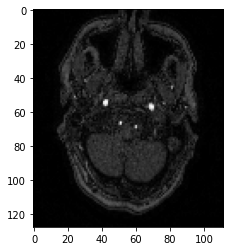

In [52]:
X_aug = random_gaussianfilter3d(X, 0.2)
fig, ax = plt.subplots()
pos = ax.imshow(np.squeeze(X_aug[:, :, 10]), cmap="gray")

In [31]:
@tf.function
def augment_3d_one(volume):
    """Rotate the volume by a few degrees"""

    def augment(volume):
        rand = np.random.randint(0,6)
        
        if IMAGE_DIMENSION == (128, 112, 40) or IMAGE_DIMENSION == (160, 140, 50) :
            if rand == 0:
                volume = random_zoom3d(volume, 0.8, 1.3)
            if rand == 1:
                volume = random_rotate3d(volume, -20, 20, -5, 5, -5, 5)
            if rand == 2:
                volume = random_shift3d(volume, -20, 20, -20, 20, 0, 0) #do not shift in z direction
            if rand == 3:
                volume = random_flip3d(volume)
            if rand == 4:
                volume = random_gaussianfilter3d(volume, 0.2)
            if rand == 5:
                volume = volume
            
        if IMAGE_DIMENSION == (64,56,20):
            if rand == 0:
                volume = random_zoom3d(volume, 0.8,1.00) 
            if rand == 1:
                volume = random_rotate3d(volume, -20, 20, -10, 10, 0, 0)
            if rand == 2:
                #volume = random_shift3d(volume, -5, 5, -5, 5, 0, 0) #do not shift in z direction
                volume = random_shift3d(volume, -10, 10, -10, 10, 0, 0) #do not shift in z direction
            if rand == 3:
                volume = random_flip3d(volume)
            if rand == 4:
                volume = random_gaussianfilter3d(volume, 0.2)
            if rand == 5:
                volume = volume

        return volume
    
    volume_shape = volume.shape
    augmented_volume = tf.numpy_function(augment, [volume], np.float64)
    augmented_volume = tf.reshape(augmented_volume, volume_shape)
    return augmented_volume

In [32]:
def train_preprocessing(volume, label):
    """Process training data by rotating and adding a channel."""
    volume = augment_3d_one(volume)
    return volume, label

### Define data loaders

In [65]:
# Define data loaders.
bool_train_labels = Y_train[:,1] != 0
#bool_train_labels = Y_train != 0 #sigmoid
pos_features = X_train[bool_train_labels]
neg_features = X_train[~bool_train_labels]
pos_labels = Y_train[bool_train_labels]
neg_labels = Y_train[~bool_train_labels]

BUFFER_SIZE = 500

def make_ds(features, labels):
  ds = tf.data.Dataset.from_tensor_slices((features, labels))#.cache()
  ds = ds.shuffle(BUFFER_SIZE).repeat()
  return ds

pos_ds = make_ds(pos_features, pos_labels)
neg_ds = make_ds(neg_features, neg_labels)

resampled_ds = tf.data.experimental.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
validation_loader = tf.data.Dataset.from_tensor_slices((X_valid, Y_valid))

batch_size = 2
# Augment the on the fly during training.
resampled_data = (
    
    resampled_ds.shuffle(buffer_size = (len(pos_features)*2), reshuffle_each_iteration=True)
    .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

# Only rescale.
validation_dataset = (
    validation_loader.shuffle(len(X_test))
    .batch(batch_size)
    .prefetch(2)
)

pos = len(pos_features)
neg = len(neg_features)
total = pos + neg
resampled_steps_per_epoch = np.ceil(2.0*pos/batch_size)

weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.63
Weight for class 1: 0.72


Dimension of the CT scan is: (50, 160, 140, 3)


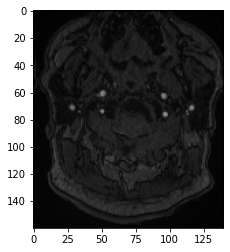

In [35]:
data = resampled_data.take(1)
images, labels = list(data)[0]
images = images.numpy()
image = images[0]
print("Dimension of the CT scan is:", image.shape)
plt.imshow(np.squeeze(image[0, :, :]), cmap="gray")

### Build CNN

In [1]:
tf.keras.backend.clear_session()

NameError: name 'tf' is not defined

In [102]:
def reset_keras():
    """
    Resets the Tensorflow graph and clears the session. Should be executed after eevery traning session with a model.

    :return:
    """
    sess = tf.compat.v1.keras.backend.get_session()
    tf.keras.backend.clear_session()
    sess.close()
    sess = tf.compat.v1.keras.backend.get_session()

    try:
        del model # this is from global space - change this as you need
    except:
        pass

    print(gc.collect()) # if it's done something you should see a number being outputted

    # use the same config as you used to create the session
    config = ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 1
    config.gpu_options.visible_device_list = "0"
    tf.compat.v1.keras.backend.set_session(Session(config=config))

In [103]:
reset_keras()

162


### Build CNN

In [51]:
X_train[0].shape

(50, 160, 140, 3)

In [66]:
conv_base = Inception_Inflated3d(include_top = False,
                             weights = 'rgb_imagenet_and_kinetics',
                             input_shape = X_train[0].shape)
conv_base.summary()

Model: "i3d_inception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 40, 128, 112 0                                            
__________________________________________________________________________________________________
Conv3d_1a_7x7_conv (Conv3D)     (None, 20, 64, 56, 6 65856       input_3[0][0]                    
__________________________________________________________________________________________________
Conv3d_1a_7x7_bn (BatchNormaliz (None, 20, 64, 56, 6 192         Conv3d_1a_7x7_conv[0][0]         
__________________________________________________________________________________________________
Conv3d_1a_7x7 (Activation)      (None, 20, 64, 56, 6 0           Conv3d_1a_7x7_bn[0][0]           
______________________________________________________________________________________

In [67]:
conv_base.trainable = False

In [76]:
inputs = keras.Input(shape=X_train[0].shape)
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
x = conv_base(inputs, training=False)

# Convert features of shape `base_model.output_shape[1:]` to vectors
#x = keras.layers.Flatten()(x)
x = keras.layers.GlobalMaxPooling3D()(x)

# Dense layer with 32 neurons
x = keras.layers.Dense(units = 32, activation = 'relu')(x)

# A Dense classifier with a single unit (binary classification)
outputs = keras.layers.Dense(units = 2, activation='softmax', kernel_initializer='random_uniform')(x)
model = keras.Model(inputs, outputs)

In [77]:
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 40, 128, 112, 3)] 0         
_________________________________________________________________
i3d_inception (Functional)   (None, 4, 1, 1, 1024)     12294544  
_________________________________________________________________
global_max_pooling3d (Global (None, 1024)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 32)                32800     
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 66        
Total params: 12,327,410
Trainable params: 32,866
Non-trainable params: 12,294,544
_________________________________________________________________


### Only train classification layer

#### Compile model

In [78]:
### define metrics
metrics = [
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.AUC(name='auc')]

### prepare files for logging
if os.path.exists('results.csv'):
    os.remove('results.csv')
    
shutil.rmtree('History')
os.makedirs('History')
    
filepath = 'History/model.epoch{epoch:02d}.hdf5'
    
### define callback_list
callback_list = [
    keras.callbacks.ModelCheckpoint(filepath=filepath, save_freq='epoch', verbose=1), 
    keras.callbacks.CSVLogger('results.csv')]
    
model.compile(loss = "categorical_crossentropy", 
              #optimizer=keras.optimizers.Adam(learning_rate = 0.0000001)
              optimizer = keras.optimizers.RMSprop(learning_rate = 0.000001),
              metrics = metrics)

In [79]:
initial_epochs = 10
history = model.fit(
    resampled_data,
    validation_data=validation_dataset,
    epochs=initial_epochs,
    verbose=1,
    callbacks=callback_list, 
    steps_per_epoch = resampled_steps_per_epoch)

Epoch 1/10
211/211 [==============================] - 102s 369ms/step - loss: 0.7015 - accuracy: 0.4774 - auc: 0.5243 - val_loss: 0.7656 - val_accuracy: 0.3235 - val_auc: 0.2779

Epoch 00001: saving model to History/model.epoch01.hdf5
Epoch 2/10
211/211 [==============================] - 71s 338ms/step - loss: 0.6846 - accuracy: 0.5500 - auc: 0.5835 - val_loss: 0.7645 - val_accuracy: 0.3235 - val_auc: 0.2819

Epoch 00002: saving model to History/model.epoch02.hdf5
Epoch 3/10
211/211 [==============================] - 66s 313ms/step - loss: 0.7108 - accuracy: 0.4743 - auc: 0.4668 - val_loss: 0.7598 - val_accuracy: 0.3235 - val_auc: 0.2818

Epoch 00003: saving model to History/model.epoch03.hdf5
Epoch 4/10
211/211 [==============================] - 71s 336ms/step - loss: 0.6962 - accuracy: 0.5325 - auc: 0.5229 - val_loss: 0.7598 - val_accuracy: 0.3235 - val_auc: 0.2789

Epoch 00004: saving model to History/model.epoch04.hdf5
Epoch 5/10
211/211 [==============================] - 68s 322ms

In [80]:
conv_base.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(conv_base.layers))

Number of layers in the base model:  195


In [81]:
# Fine-tune from this layer onwards
fine_tune_at = 5

# Freeze all the layers before the `fine_tune_at` layer
for layer in conv_base.layers[:fine_tune_at]:
  layer.trainable =  False

In [82]:
### define metrics
metrics = [
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.AUC(name='auc')]

### prepare files for logging
if os.path.exists('results.csv'):
    os.remove('results.csv')
    
shutil.rmtree('History')
os.makedirs('History')
    
filepath = 'History/model.epoch{epoch:02d}.hdf5'
    
### define callback_list
callback_list = [
    keras.callbacks.ModelCheckpoint(filepath=filepath, save_freq='epoch', verbose=1), 
    keras.callbacks.CSVLogger('results.csv')]
    
model.compile(loss = "categorical_crossentropy", 
              optimizer = keras.optimizers.RMSprop(learning_rate = 0.00001),
              metrics = metrics)

In [83]:
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 40, 128, 112, 3)] 0         
_________________________________________________________________
i3d_inception (Functional)   (None, 4, 1, 1, 1024)     12294544  
_________________________________________________________________
global_max_pooling3d (Global (None, 1024)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 32)                32800     
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 66        
Total params: 12,327,410
Trainable params: 12,246,930
Non-trainable params: 80,480
_________________________________________________________________


In [84]:
fine_tune_epochs = 30
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(resampled_data,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset, 
                         callbacks=callback_list,
                         steps_per_epoch = resampled_steps_per_epoch)

Epoch 10/40


ResourceExhaustedError: 2 root error(s) found.
  (0) Resource exhausted:  OOM when allocating tensor with shape[3,3,3,48,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node RMSprop/RMSprop/update_106/mul_2 (defined at <ipython-input-84-da587bb0e8a2>:9) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[assert_greater_equal/Assert/AssertGuard/branch_executed/_9/_59]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

  (1) Resource exhausted:  OOM when allocating tensor with shape[3,3,3,48,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node RMSprop/RMSprop/update_106/mul_2 (defined at <ipython-input-84-da587bb0e8a2>:9) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_122558]

Function call stack:
train_function -> train_function


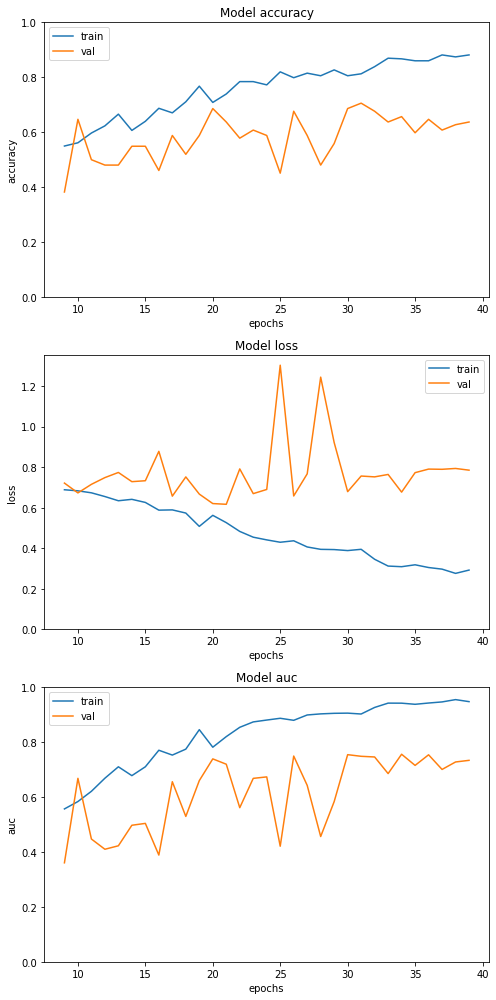

In [41]:
dat = pd.read_csv('results.csv', index_col='epoch')

fig, ax = plt.subplots(3, 1, figsize=(7,14))
metrics = ['accuracy', 'loss', 'auc']

for i, metric in enumerate(metrics):
    ax[i].plot(dat[metric])
    ax[i].plot(dat['val_'+metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])
    
    if metric == 'accuracy' or metric == 'auc':
        ax[i].set_ylim(0,1)
        
    else:
        ax[i].set_ylim(0)
    
fig.tight_layout()
plt.show()

p = 'softmax'+str(IMAGE_DIMENSION)
fig.savefig(p)

### Check best model

In [34]:
best_model = np.where(dat.val_loss == np.min(dat.val_loss))[0][0] 
print(best_model)

model.load_weights('History/model.epoch' + str(best_model) + '.hdf5')

4


OSError: Unable to open file (unable to open file: name = 'History/model.epoch4.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [42]:
y_prob = model.predict(X_valid, batch_size=batch_size)
y_pred = (y_prob[:,1] > 0.5).astype(np.int)

y_valid = Y_valid.argmax(axis = 1) 

auc, auc_var, ci_auc = auc_ci_Delong(
    y_true=y_valid,
    y_scores=y_prob[:,1])

cm = confusion_matrix(y_valid, y_pred)
lower_acc, upper_acc = proportion_confint(sum(np.diag(cm)), np.sum(cm), 0.05, method = 'wilson')
lower_acc = round(lower_acc, 4)
upper_acc = round(upper_acc,4)

print("Accuracy: ", round((np.mean(y_pred == y_valid)*100),2), ' CI:', lower_acc, upper_acc)
print("AUC: ", sklearn.metrics.roc_auc_score(y_valid, y_prob[:,1]).round(3), 'CI:', np.round(ci_auc,3))
print("Confusion matrix: \n", 
      confusion_matrix(y_valid, y_pred))
print("Normalized Confusion matrix: \n", 
      confusion_matrix(y_valid, y_pred, normalize = 'true'))

Accuracy:  63.73  CI: 0.5405 0.724
AUC:  0.668 CI: [0.558 0.779]
Confusion matrix: 
 [[10 22]
 [15 55]]
Normalized Confusion matrix: 
 [[0.3125     0.6875    ]
 [0.21428571 0.78571429]]


In [43]:
### training
y_prob = model.predict(X_train, batch_size=batch_size)
y_pred = (y_prob[:,1] > 0.5).astype(np.int)

y_train = Y_train.argmax(axis = 1) 

cm = confusion_matrix(y_train, y_pred)
lower_acc, upper_acc = proportion_confint(sum(np.diag(cm)), np.sum(cm), 0.05, method = 'wilson')
ci_acc = np.array([lower_acc, upper_acc])

auc, auc_var, ci_auc = auc_ci_Delong(
    y_true=y_train,
    y_scores=y_prob[:,1])

print("Accuracy: ", round((np.mean(y_pred == y_train)*100),2), ' CI:', np.round(ci_acc,3) )
print("AUC: ", round(auc, 3), 'CI:', np.round(ci_auc, 3))
print("Confusion matrix: \n", 
      confusion_matrix(y_train, y_pred))
print("Normalized Confusion matrix: \n", 
      np.round(confusion_matrix(y_train, y_pred, normalize = 'true'),3))

Accuracy:  100.0  CI: [0.988 1.   ]
AUC:  1.0 CI: [nan nan]
Confusion matrix: 
 [[ 93   0]
 [  0 211]]
Normalized Confusion matrix: 
 [[1. 0.]
 [0. 1.]]


/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:2023: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:2024: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


In [44]:
bool_test_labels = Y_valid[:,1] != 0
pos_features_test = X_valid[bool_test_labels]
neg_features_test = X_valid[~bool_test_labels]
pos_labels_test = Y_valid[bool_test_labels]
neg_labels_test = Y_valid[~bool_test_labels]

ids = np.arange(len(neg_features_test))
choices = np.random.choice(ids, len(pos_features_test))
res_neg_features = neg_features_test[choices]
res_neg_labels = neg_labels_test[choices]

resampled_features = np.concatenate([res_neg_features, pos_features_test], axis=0)
resampled_labels = np.concatenate([res_neg_labels, pos_labels_test], axis=0)

order = np.arange(len(resampled_labels))
np.random.shuffle(order)
X_valid_balanced = resampled_features[order]
Y_valid_balanced  = resampled_labels[order]

y_prob = model.predict(X_valid_balanced, batch_size=batch_size)
y_pred = (y_prob[:,1] > 0.5).astype(np.int)

y_valid_balanced = Y_valid_balanced.argmax(axis = 1) 

cm = confusion_matrix(y_valid_balanced, y_pred)
lower_acc, upper_acc = proportion_confint(sum(np.diag(cm)), np.sum(cm), 0.05, method = 'wilson')
ci_acc = np.array([lower_acc, upper_acc])

auc, auc_var, ci_auc = auc_ci_Delong(
    y_true=y_valid_balanced,
    y_scores=y_prob[:,1])

print("Accuracy: ", round((np.mean(y_pred == y_valid_balanced)*100),2), ' CI:', np.round(ci_acc,3) )
print("AUC: ", round(auc, 3), 'CI:', np.round(ci_auc, 3))
print("Confusion matrix: \n", 
      confusion_matrix(y_valid_balanced, y_pred))
print("Normalized Confusion matrix: \n", 
      np.round(confusion_matrix(y_valid_balanced, y_pred, normalize = 'true'),3))

Accuracy:  54.29  CI: [0.46  0.623]
AUC:  0.66 CI: [0.569 0.752]
Confusion matrix: 
 [[21 49]
 [15 55]]
Normalized Confusion matrix: 
 [[0.3   0.7  ]
 [0.214 0.786]]


In [52]:
y_prob = model.predict(X_test, batch_size=batch_size)
y_pred = (y_prob[:,1] > 0.5).astype(np.int)

y_test = Y_test.argmax(axis = 1) 

auc, auc_var, ci_auc = auc_ci_Delong(
    y_true=y_test,
    y_scores=y_prob[:,1])

cm = confusion_matrix(y_test, y_pred)
lower_acc, upper_acc = proportion_confint(sum(np.diag(cm)), np.sum(cm), 0.05, method = 'wilson')
lower_acc = round(lower_acc, 4)
upper_acc = round(upper_acc,4)

print("Accuracy: ", round((np.mean(y_pred == y_test)*100),2), ' CI:', lower_acc, upper_acc)
print("AUC: ", np.round(auc,3), 'CI:', np.round(ci_auc,3))
print("Confusion matrix: \n", 
      confusion_matrix(y_test, y_pred))
print("Normalized Confusion matrix: \n", 
      confusion_matrix(y_test, y_pred, normalize = 'true'))

Accuracy:  66.67  CI: 0.5706 0.7506
AUC:  0.545 CI: [0.42 0.67]
Confusion matrix: 
 [[10 22]
 [12 58]]
Normalized Confusion matrix: 
 [[0.3125     0.6875    ]
 [0.17142857 0.82857143]]


In [59]:
list(y_test)

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0]